# Retroperitoneal sarcoma radiomics study
# Prediction of tumour type and grade
# Logistic regression with group selection

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500, 'display.max_rows', 500, 'display.precision', 3)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_validate
import os, warnings, copy, sys, shutil
import matplotlib.pyplot as plt
import pickle
from time import strftime, localtime
from pyirr import intraclass_correlation
from scipy.stats import skew
import seaborn as sns
from scipy.stats import mannwhitneyu

rootFolder = os.path.join(os.path.expanduser("~"), 'Dicom Files/RADSARC_R')

# this module should be in the same folder as this notebook
from fit_LR_groupSelection_correlationThresholds import fit_LR_groupSelection_correlationThresholds, plotResultExperiments, displayOneExperiment

n_splits = 10
n_repeats = 5
thresholds = np.round(np.arange(0.6,1.00001,0.02), 2)
penalty = 'l1'

displayAll = True

## Create output and copy code

In [2]:
%%capture out_stream

# set output folder to None if this is a fresh run
# set output folder to an existing location to load pre-saved results from there
outputFolder = None #'/Users/morton/Dicom Files/RADSARC_R/XNAT/experiments/LR_GroupSelection__20220924_0958'

if outputFolder is None:
    
    saveOutputs = True
    
    outputFolder = os.path.join(rootFolder, 'XNAT/experiments/LR_GroupSelection__' + strftime("%Y%m%d_%H%M", localtime()))
    os.mkdir(outputFolder)
    os.mkdir(os.path.join(outputFolder, 'code'))
    os.mkdir(os.path.join(outputFolder, 'figures'))

    jupyterFile = 'LR_GroupSelection_withValidation_andOutcome_andClinical.ipynb'
    jupyterPath = os.path.join(os.path.abspath(""), jupyterFile)
    jupyterDestin = os.path.join(outputFolder, 'code', jupyterFile)
    shutil.copyfile(jupyterPath, jupyterDestin)

    file1 = 'fit_LR_groupSelection_correlationThresholds.py'
    file1path = os.path.join(os.path.abspath(""), file1)
    file1destin = os.path.join(outputFolder, 'code', file1)
    shutil.copyfile(file1path, file1destin)

    user = os.path.expanduser("~")
    file2 = os.path.join(user, 'Documents/git/git_icrpythonradiomics/machineLearning/featureSelection.py')
    shutil.copyfile(file2, os.path.join(outputFolder, 'code', 'featureSelection.py'))

else:
    
    saveOutputs = False

### Utility functions

In [3]:
def groupStrsDisp(strGroups):
    
    def tidyGroup(strGroup):
        if strGroup == '':
            strGroup = 'all'
        strGroup = strGroup.replace('glcm|gldm|glszm|glrlm|ngtdm','texture')
        strGroup = strGroup.replace('firstorder|histogram','firstorder')
        return strGroup

    if isinstance(strGroups, str):
        return tidyGroup(strGroups)
    
    if isinstance(strGroups, list):
        return [tidyGroup(x) for x in strGroups]

## Load data

In [4]:
# TRAINING DATA

# open clinical spreadsheet
clinicalSpreadsheet = os.path.join(rootFolder, 'ClinicalData', 'Clinical data for analysis.xlsx')
dfClinical = pd.read_excel(clinicalSpreadsheet, sheet_name='220818_Completed segs', header = 2, skiprows=[3], nrows=170, engine='openpyxl')
dfClinical.sort_values('Anon Code', inplace=True, ignore_index=True)

# simplify grade
dfClinical['Grade_1_234'] = dfClinical['Grade']==1
dfClinical['Grade_12_34'] = dfClinical['Grade']<=2

# binarised outcome data
cutoffYears = 1.5
cutoffDays = cutoffYears*365

# Recurrence data are for local (arfs) and distant (dmfs) metastases
# Combine these into an overall recurrence status, i.e. if either arfs==1 or dmfs==1 then rfs==1, and then the 
# recurrence time is the shorter of the two
dfClinical.drop(['rfs', 't_rfs'], inplace=True, axis=1)
dfClinical['rfs'] = np.logical_or(dfClinical['arfs']==1, dfClinical['dmfs']==1).astype(int)
dfClinical['t_rfs'] = dfClinical[['t_arfs', 't_dmfs']].min(axis=1)

def binarizeOutcome(df, new_val1, new_val2, old_val2, feat_time, feat_event, new_feat_name):

    df[new_feat_name] = new_val1
    df.loc[df[feat_time] >= cutoffDays, new_feat_name] = new_val2
    df.loc[np.logical_and(df[feat_time] < cutoffDays, df[feat_event] == old_val2), new_feat_name] = 'Unknown'

binarizeOutcome(dfClinical, 'Event', 'No event', 'Alive', 't_os', 'os', 'overall_survival')
binarizeOutcome(dfClinical, 'Event', 'No event', 0, 't_dmfs', 'dmfs', 'distant_recurrence')
binarizeOutcome(dfClinical, 'Event', 'No event', 0, 't_arfs', 'arfs', 'local_recurrence')
binarizeOutcome(dfClinical, 'Event', 'No event', 0, 't_rfs', 'rfs', 'any_recurrence')

# rename some clinical features that will be used in the outcome models
# can use sub-string "clinical" to remove these features for models of tumour type and grade
dfClinical['clinical_Age'] = dfClinical['Age']
dfClinical['clinical_ECOG'] = dfClinical['ECOG at Diagnosis']
sexMap = {'Female':0, 'Male':1}
dfClinical['clinical_Sex'] = dfClinical.Sex.map(sexMap)
dfClinical['clinical_Grade'] = dfClinical['Grade']    # don't binarize when using as input feature
dfClinical['clinical_Size'] = dfClinical['Size ']
subtypeMap = {'LMS':0, 'LPS':1}
dfClinical['clinical_Subtype'] = dfClinical.subtype.map(subtypeMap)

# Radiation_neoadj needed to exclude patients that had radiotherapy (3 patients)
cols = ['Anon Code', 
        'Grade_1_234', 
        'Grade_12_34', 
        'subtype', 
        'overall_survival', 
        'distant_recurrence',
        'local_recurrence',
        'any_recurrence',
        'Radiation_neoadj',
        'clinical_Sex',
        'clinical_Grade',
        'clinical_Size',
        'clinical_Subtype']
#         'clinical_Age',   # is in dicom header for 66/89 EORTC patients
#         'clinical_ECOG',  # not present in EORTC data

dfClinical = dfClinical[cols]

sizeBefore = dfClinical.shape[0]
dfClinical.dropna(inplace=True)
print('Number of dropped patients = ' + str(sizeBefore - dfClinical.shape[0]))


# TEST DATA

# open clinical spreadsheet
clinicalSpreadsheetTest = os.path.join(rootFolder, 'ClinicalData', 'EORTC_Radsarc_Clindata.xlsx')
dfClinicalTest = pd.read_excel(clinicalSpreadsheetTest, sheet_name='Completed segs_for analysis', engine='openpyxl')
dfClinicalTest['Anon Code'] = ['EORTCRSRC_' + str(int(x)).zfill(3) for x in dfClinicalTest['PATID']]

# simplify grade
dfClinicalTest['Grade_1_234'] = dfClinicalTest['grade']==1
dfClinicalTest['Grade_12_34'] = dfClinicalTest['grade']<=2

# make rfs data

dfClinicalTest['rfs'] = np.logical_or(dfClinicalTest['arfs2']==1, dfClinicalTest['dmfs']==1).astype(int)
dfClinicalTest['t_rfs'] = dfClinicalTest[['t_arfs2', 't_dmfs']].min(axis=1)

# binarised outcome data
binarizeOutcome(dfClinicalTest, 'Event', 'No event', 1, 't_ss', 'ss', 'overall_survival')
binarizeOutcome(dfClinicalTest, 'Event', 'No event', 1, 't_dmfs', 'dmfs', 'distant_recurrence')
binarizeOutcome(dfClinicalTest, 'Event', 'No event', 1, 't_arfs2', 'arfs2', 'local_recurrence')
binarizeOutcome(dfClinicalTest, 'Event', 'No event', 1, 't_rfs', 'rfs', 'any_recurrence')

# add this column to match training data
dfClinicalTest['Radiation_neoadj'] = 0

dfClinicalTest['clinical_Sex'] = dfClinicalTest.Sex.map(sexMap)
dfClinicalTest['clinical_Grade'] = dfClinicalTest['grade']
dfClinicalTest['clinical_Size'] = dfClinicalTest['rpmeasim']
dfClinicalTest['clinical_Subtype'] = dfClinicalTest.subtype.map(subtypeMap)

dfClinicalTest = dfClinicalTest[cols]


Number of dropped patients = 2


In [5]:
def readRadData(folder):
    df = pd.read_csv(os.path.join(rootFolder, 'XNAT', 'extractions', folder, 'radiomicFeatures', 'radiomicFeatures.csv'))
    df.drop(list(df.filter(regex = 'source')), axis = 1, inplace = True)
    df.drop(list(df.filter(regex = 'diagnostic')), axis = 1, inplace = True)
    df.drop(list(df.filter(regex = 'histogram')), axis = 1, inplace = True)
    return df

# training
dfRad = readRadData('extractions__20221122_1628_allRegions_volFracApprox')

# reproducibility
dfRadRep = readRadData('extractions__20221122_2037_repro_volFracApprox')

# open test data
dfRadTest = readRadData('extractions__20221125_0939_eortcTestData')

## Compute ICCs and remove unreproducible features

In [6]:
dfRadOri = dfRad.copy()

subjectIDs = dfRadOri.merge(dfRadRep, on='StudyPatientName').StudyPatientName

# select rows and make sure they are both sorted on SubjectID
dfRadOri = dfRadOri.loc[dfRadOri['StudyPatientName'].isin(subjectIDs)]
dfRadOri.sort_values('StudyPatientName', axis=0, inplace=True)

dfRadRep = dfRadRep.loc[dfRadRep['StudyPatientName'].isin(subjectIDs)]
dfRadRep.sort_values('StudyPatientName', axis=0, inplace=True)

# remove high/mid/low_enhancing features
dfRadOri.drop(list(dfRadOri.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
dfRadOri.drop(list(dfRadOri.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
dfRadOri.drop(list(dfRadOri.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)

# remove these features
dfRadOri.drop(list(dfRadOri.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)

dfRadOri.reset_index(inplace=True)
dfRadRep.reset_index(inplace=True)

iccValues = []
featNames = []
for col in dfRadOri.columns:
    if col == 'StudyPatientName' or col=='index':
        continue
    data = np.stack((dfRadOri[col], dfRadRep[col]), axis=1)
    featNames.append(col)
    iccValues.append(intraclass_correlation(data, "twoway", "agreement").value)
iccDf = pd.DataFrame({'Feature':featNames, 'ICC':iccValues})

iccThreshold = 0.75

reproducibleFeatures = list(iccDf.Feature[iccDf.ICC>iccThreshold])
reproducibleFeatures.append('StudyPatientName')

dfRad = dfRad.filter(reproducibleFeatures)
dfRadTest = dfRadTest.filter(reproducibleFeatures)

## Log transform positive skewed parameters

In [7]:
def makeLog(df, feat, offset=0):
    df[feat+'_log'] = np.log(df[feat]+offset)
    df.drop(feat, axis=1, inplace=True)
    return df

for feat in dfRad.filter(regex='lesion_original', axis=1).columns:
    if skew(dfRad[feat])>3 and np.all(dfRad[feat]>0):
        dfRad = makeLog(dfRad, feat)
        dfRadTest = makeLog(dfRadTest, feat)

# this is heavily skewed, but has minimum value -87
dfRad = makeLog(dfRad, 'lesion_original_glcm_ClusterShade', offset=90)
dfRadTest = makeLog(dfRadTest, 'lesion_original_glcm_ClusterShade', offset=90)

In [8]:
def featureClassDensities(df_Train, df_Test, featureClass, spSize):
    f,a = plt.subplots(spSize[0], spSize[1], figsize=(20,12))
    a = a.ravel()
    for n, feat in enumerate(df_Train.filter(regex = featureClass, axis = 1).columns):
        df1 = pd.DataFrame(df_Train[feat].copy())
        df1['Data'] = 'train'
        df2 = pd.DataFrame(df_Test[feat].copy())
        df2['Data'] = 'test'
        dfPlot = pd.concat([df1, df2])
        dfPlot.reset_index(drop=True, inplace=True)
        featPlot = feat.replace('lesion_original_' + featureClass + '_','')
        dfPlot.rename(columns={feat:featPlot}, inplace=True)
        sns.kdeplot(data=dfPlot, x=featPlot, hue='Data', ax = a[n], common_grid=True, common_norm=False)

if False:
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'shape', (3, 5))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'firstorder', (3,6))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'glcm', (4,6))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'glrlm', (4,4))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'glszm', (4,4))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'gldm', (3,5))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'ngtdm', (2,3))


## Useful functions

In [9]:
def prepData(dfC, dfR, target, featureSet, removeTargetUnknown=True, replaceTargetUnknown=None, removeRxPatients=False):
    
    df = dfC.merge(dfR, left_on='Anon Code', right_on='StudyPatientName')
    df.drop('Anon Code', axis=1, inplace=True)
    df.drop('StudyPatientName', axis=1, inplace=True)
    
    # remove any patients that had radiotherapy
    if removeRxPatients:
        df = df.loc[df['Radiation_neoadj']!=1,:]
    
    df = df.filter(regex=featureSet + '|' + target)

    # replace any instances where target = 'Unknown' by replaceTargetUnknown
    if replaceTargetUnknown is not None:
        df.loc[df[target] == 'Unknown',target] = replaceTargetUnknown
        
    if removeTargetUnknown:
        df = df.loc[df[target] != 'Unknown',:]
        
        
    
    return df

def fitModelOrLoadSaved(df, target, settings, qlf):
    
    if os.path.exists(qlf):
        with open(qlf, 'rb') as handle:
            result = pickle.load(handle)
    else:
        result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

        if saveOutputs:
            with open(qlf, 'wb') as handle:
                pickle.dump(result, handle)

    return copy.deepcopy(result)

def getTrainTestResults(result):
    
    # find best model i.e. across all thresholds
    AUROC_cv = np.array([np.mean(x['cv_result']['test_score']) for x in result['experiments']])
    idx = np.argmax(AUROC_cv)
    bestExperiment = result['experiments'][idx]

    trainScore = bestExperiment['model'].predict_proba(df.drop(target, axis=1))
    testScore = bestExperiment['model'].predict_proba(dfTest.drop(target, axis=1))
    
    aucTest = roc_auc_score(dfTest[target], testScore[:,1])
    classLabels = list(set(dfTest[target]))
 
    if aucTest>0.6:
        # get p-value on test data
        testScores0 = testScore[dfTest[target]==classLabels[0],1]
        testScores1 = testScore[dfTest[target]==classLabels[1],1]
        _, pValue = mannwhitneyu(testScores0, testScores1, alternative='two-sided')
        pValueStr = str(pValue)
    else:
        pValue = ''
        pValueStr = 'not computed'
        
    nC0 = np.sum(df[target]==classLabels[0])
    nC1 = np.sum(df[target]==classLabels[1])
    nC0t = np.sum(dfTest[target]==classLabels[0])
    nC1t = np.sum(dfTest[target]==classLabels[1])
    aucTrainResub = roc_auc_score(df[target], trainScore[:,1])
    aucTrainCV = np.mean(bestExperiment['cv_result']['test_score'])
    
    
    print('train #      = ' + str(nC0 + nC1) + ' = ' + str(nC0) + ' : ' + str(nC1) + ' (' + str(np.round(100*nC0/(nC0+nC1),1)) + '%)')
    print('train resub  = ' + str(np.round(aucTrainResub,3)))
    print('train CV     = ' + str(np.round(aucTrainCV,3)))
    print('test #       = ' + str(nC0t + nC1t) + ' = ' + str(nC0t) + ' : ' + str(nC1t) + ' (' + str(np.round(100*nC0t/(nC0t+nC1t),1)) + '%)')
    print('test         = ' + str(np.round(aucTest,3)))
    print('test p-value = ' + pValueStr)
    print('\n')

    return {'nTrainA':nC0,
            'nTrainB':nC1,
            'nTestA':nC0t,
            'nTestB':nC1t,
            'AUC train resub':aucTrainResub,
            'AUC train CV':aucTrainCV,
            'AUC test':aucTest,
            'p-value test':pValue}


## Settings for different feature sets

In [10]:
textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'

# variables are defined at the top of this notebook
defaultSettings = {'n_splits':n_splits, 
                   'n_repeats':n_repeats,
                   'thresholds':thresholds,
                   'penalty':penalty
                   }

settingsDict = {}

# standard features
fs = 'lesion_original'
settingsDict[fs] = defaultSettings.copy()
settingsDict[fs]['name'] = 'Standard radiomics features'
settingsDict[fs]['ID'] = 'standard'
settingsDict[fs]['groupHierarchy'] = ['shape',
                                      'firstorder',
                                      textureStr,
                                      'shape|firstorder',
                                      'shape|' + textureStr,
                                      'firstorder|' + textureStr,
                                      '']
settingsDict[fs]['correlationHierarchy'] = ['shape', 'firstorder']


# volume fraction + standard features
fs = 'lesion_original|VolumeFraction'
settingsDict[fs] = defaultSettings.copy()
settingsDict[fs]['name'] = 'Standard radiomics features + volume fraction'
settingsDict[fs]['ID'] = 'volFrac'
settingsDict[fs]['groupHierarchy'] = ['VolumeFraction',
                                      'shape',
                                      'firstorder',
                                      textureStr,
                                      'VolumeFraction|shape',
                                      'VolumeFraction|firstorder',
                                      'VolumeFraction|' + textureStr,
                                      'shape|firstorder',
                                      'shape|' + textureStr,
                                      'firstorder|' + textureStr,
                                      '']
settingsDict[fs]['correlationHierarchy'] = ['VolumeFraction', 'shape', 'firstorder']


# approximate volume fraction + standard features
fs = 'lesion_original|ApproxVolFraction'
settingsDict[fs] = defaultSettings.copy()
settingsDict[fs]['name'] = 'Standard radiomics features + approximate volume fraction'
settingsDict[fs]['ID'] = 'approxVolFrac'
settingsDict[fs]['groupHierarchy'] = ['ApproxVolFraction',
                                      'shape',
                                      'firstorder',
                                      textureStr,
                                      'ApproxVolFraction|shape',
                                      'ApproxVolFraction|firstorder',
                                      'ApproxVolFraction|' + textureStr,
                                      'shape|firstorder',
                                      'shape|' + textureStr,
                                      'firstorder|' + textureStr,
                                      '']
settingsDict[fs]['correlationHierarchy'] = ['ApproxVolFraction', 'shape', 'firstorder']

# clinical features
fs = 'clinical'
settingsDict[fs] = defaultSettings.copy()
settingsDict[fs]['name'] = 'Clinical features'
settingsDict[fs]['ID'] = 'clinical'
settingsDict[fs]['groupHierarchy'] = ['']
settingsDict[fs]['correlationHierarchy'] = []

# standard features
fs = 'clinical|lesion_original'
settingsDict[fs] = defaultSettings.copy()
settingsDict[fs]['name'] = 'Clinical and standard radiomics features'
settingsDict[fs]['ID'] = 'clinical + standard'
settingsDict[fs]['groupHierarchy'] = ['clinical',
                                      'clinical|shape',
                                      'clinical|firstorder',
                                      'clinical|' + textureStr,
                                      'clinical|shape|firstorder',
                                      'clinical|shape|' + textureStr,
                                      'clinical|firstorder|' + textureStr,
                                      '']
settingsDict[fs]['correlationHierarchy'] = ['clinical', 'shape', 'firstorder']


## Further settings for each target/feature set combination 

In [11]:
# featureSets = list(settingsDict.keys())
featureSets = ['clinical|lesion_original']

experiments = []

# for target in ['subtype', 'Grade_1_234', 'Grade_12_34']:
#     for featureSet in featureSets:
#         experiments.append({'target':target,
#                             'featureSet':featureSet,
#                             'removeTargetUnknown':False,
#                             'replaceTargetUnknown':None,
#                             'removeRxPatients':False})

for target in ['overall_survival', 'distant_recurrence', 'local_recurrence', 'any_recurrence']:
    for featureSet in featureSets:
        experiments.append({'target':target,
                            'featureSet':featureSet,
                            'removeTargetUnknown':True,
                            'replaceTargetUnknown':None,
                            'removeRxPatients':True})
        experiments.append({'target':target,
                            'featureSet':featureSet,
                            'removeTargetUnknown':False,
                            'replaceTargetUnknown':'No event',
                            'removeRxPatients':True})


### Run all experiments

Experiment number 0
Target      overall_survival
Features    Clinical and standard radiomics features
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


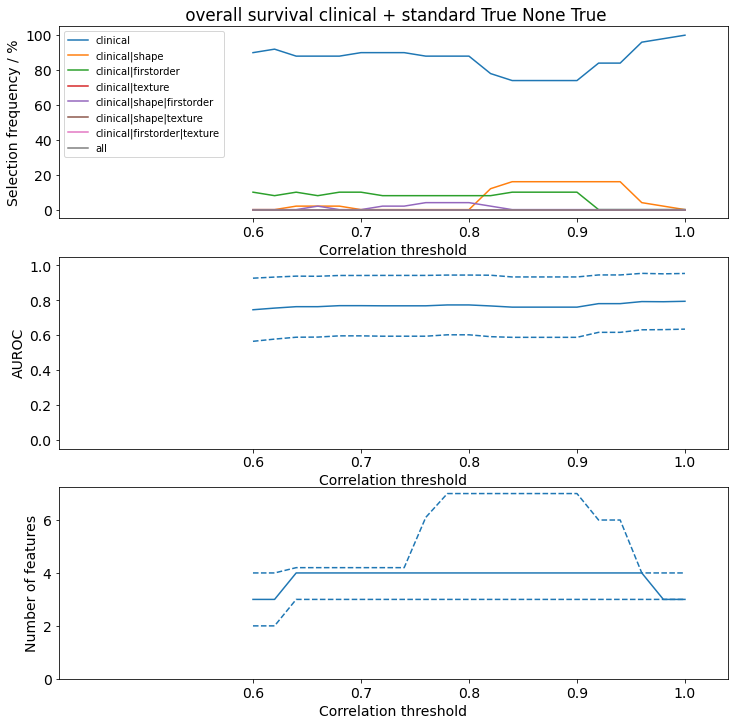

Threshold = 1.0
AUROC (CV) = 0.7944

Feature group = clinical



Feature,Frequency,Coef
clinical_Sex,100.000,-0.371
clinical_Grade,100.000,-1.259
clinical_Size,86.000,0.202
clinical_Subtype,56.000,-0.001


train #      = 144 = 123 : 21 (85.4%)
train resub  = 0.821
train CV     = 0.794
test #       = 87 = 82 : 5 (94.3%)
test         = 0.784
test p-value = 0.03438064912530105


____________________
Experiment number 1
Target      overall_survival
Features    Clinical and standard radiomics features
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


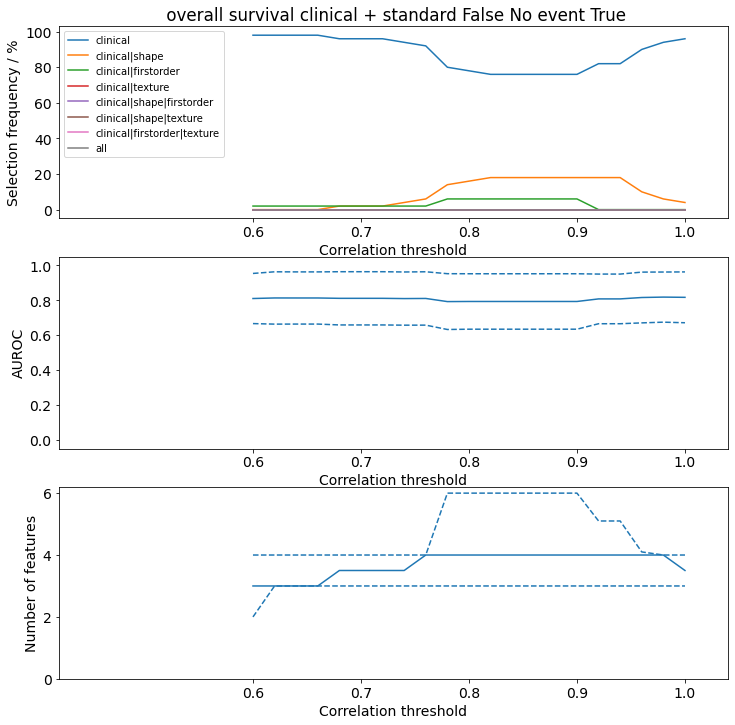

Threshold = 0.98
AUROC (CV) = 0.81843

Feature group = clinical



Feature,Frequency,Coef
clinical_Sex,100.000,-0.383
clinical_Grade,100.000,-1.294
clinical_Size,94.000,0.242


train #      = 165 = 144 : 21 (87.3%)
train resub  = 0.832
train CV     = 0.818
test #       = 89 = 84 : 5 (94.4%)
test         = 0.785
test p-value = 0.03397546431021431


____________________
Experiment number 2
Target      distant_recurrence
Features    Clinical and standard radiomics features
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


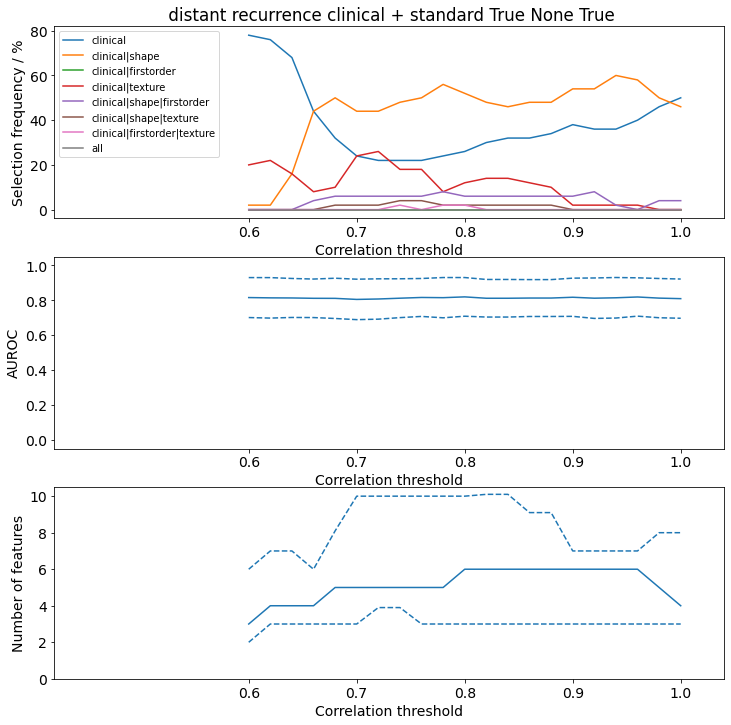

Threshold = 0.8
AUROC (CV) = 0.8197

Feature group = clinical|shape



Feature,Frequency,Coef
clinical_Grade,100.000,-1.464
clinical_Subtype,98.000,0.405
clinical_Sex,94.000,0.136
lesion_original_shape_Sphericity,60.000,0.659
lesion_original_shape_Flatness,56.000,-0.301
lesion_original_shape_SurfaceVolumeRatio_log,22.000,-0.079


train #      = 138 = 110 : 28 (79.7%)
train resub  = 0.864
train CV     = 0.82
test #       = 87 = 75 : 12 (86.2%)
test         = 0.649
test p-value = 0.10032679195749464


____________________
Experiment number 3
Target      distant_recurrence
Features    Clinical and standard radiomics features
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


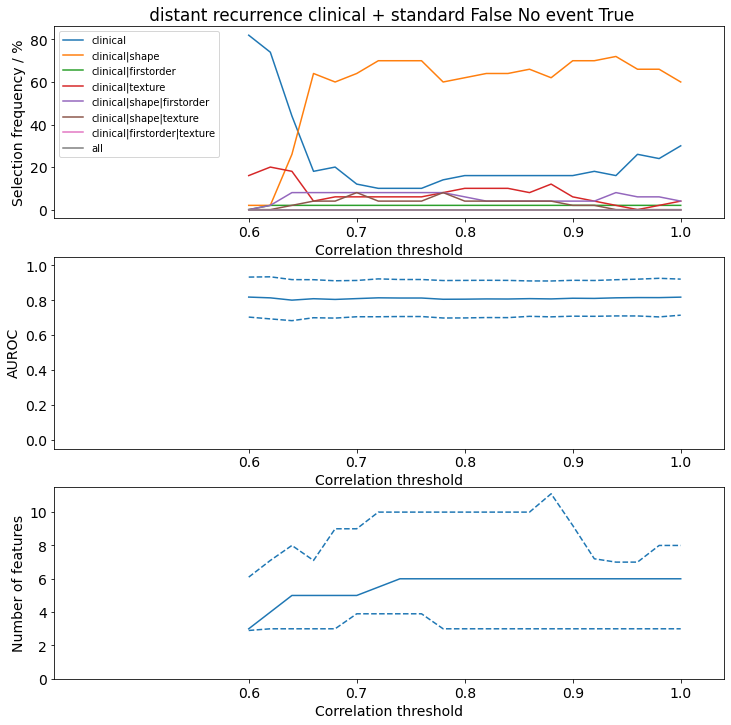

Threshold = 0.6
AUROC (CV) = 0.81853

Feature group = clinical



Feature,Frequency,Coef
clinical_Sex,100.000,0.342
clinical_Grade,100.000,-1.431


train #      = 165 = 137 : 28 (83.0%)
train resub  = 0.826
train CV     = 0.819
test #       = 89 = 77 : 12 (86.5%)
test         = 0.619
test p-value = 0.18205196880906782


____________________
Experiment number 4
Target      local_recurrence
Features    Clinical and standard radiomics features
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


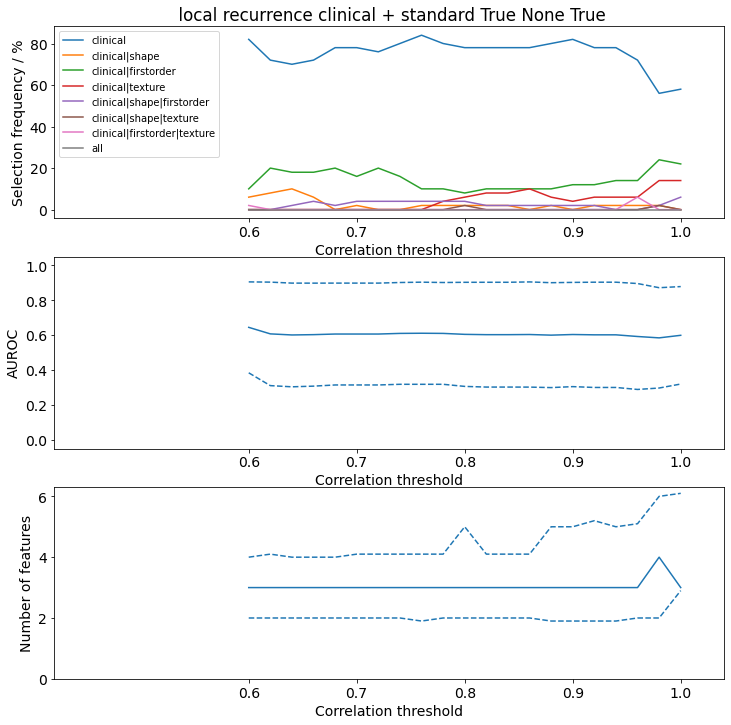

Threshold = 0.6
AUROC (CV) = 0.645

Feature group = clinical



Feature,Frequency,Coef
clinical_Grade,100.000,-0.695
clinical_Sex,90.000,-0.195
clinical_Subtype,62.000,-0.193


train #      = 129 = 113 : 16 (87.6%)
train resub  = 0.717
train CV     = 0.645
test #       = 87 = 75 : 12 (86.2%)
test         = 0.588
test p-value = not computed


____________________
Experiment number 5
Target      local_recurrence
Features    Clinical and standard radiomics features
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


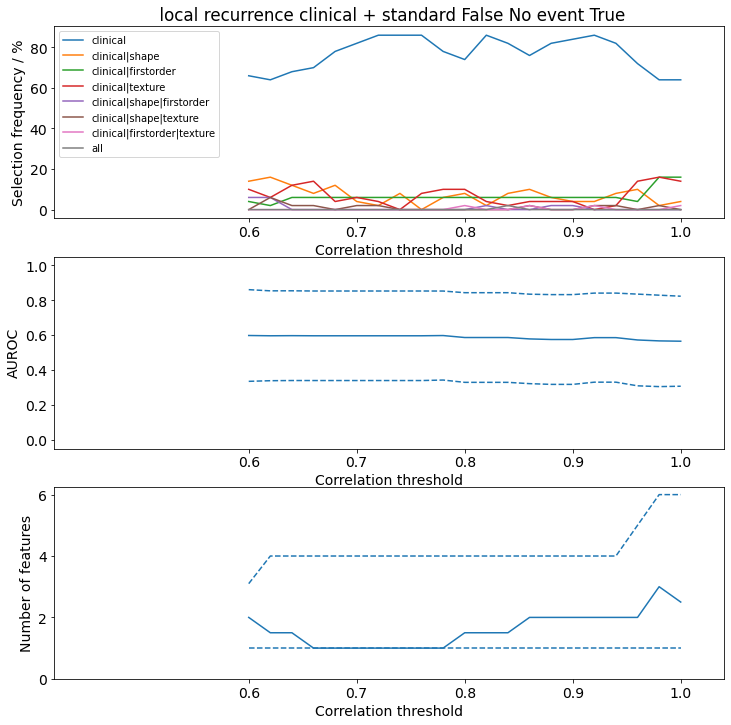

Threshold = 0.6
AUROC (CV) = 0.59829

Feature group = clinical



Feature,Frequency,Coef
clinical_Grade,100.000,-0.408
clinical_Sex,46.000,-0.097


train #      = 165 = 149 : 16 (90.3%)
train resub  = 0.673
train CV     = 0.598
test #       = 89 = 77 : 12 (86.5%)
test         = 0.578
test p-value = not computed


____________________
Experiment number 6
Target      any_recurrence
Features    Clinical and standard radiomics features
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


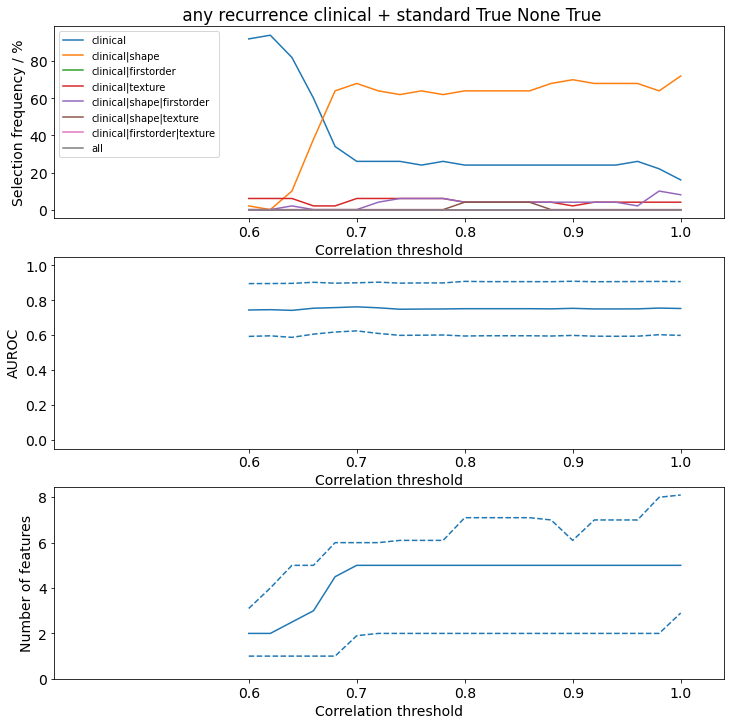

Threshold = 0.7
AUROC (CV) = 0.76257

Feature group = clinical|shape



Feature,Frequency,Coef
clinical_Grade,100.000,-1.307
clinical_Size,80.000,0.277
clinical_Subtype,76.000,0.163
lesion_original_shape_Sphericity,68.000,0.654
lesion_original_shape_Elongation,48.000,-0.109
clinical_Sex,34.000,-0.040


train #      = 141 = 101 : 40 (71.6%)
train resub  = 0.82
train CV     = 0.763
test #       = 79 = 69 : 10 (87.3%)
test         = 0.648
test p-value = 0.1345140716245875


____________________
Experiment number 7
Target      any_recurrence
Features    Clinical and standard radiomics features
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


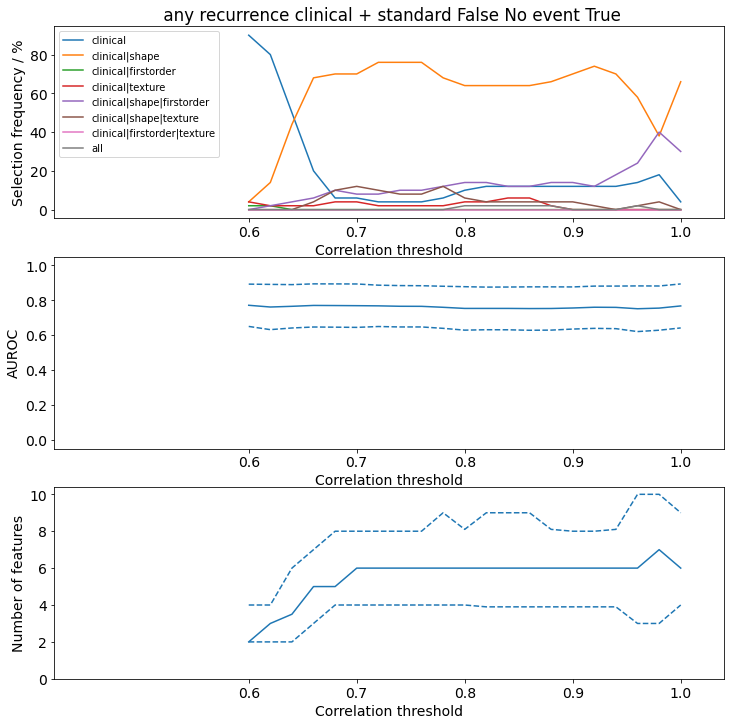

Threshold = 0.6
AUROC (CV) = 0.77154

Feature group = clinical



Feature,Frequency,Coef
clinical_Grade,100.000,-1.155
clinical_Size,54.000,0.168


train #      = 165 = 125 : 40 (75.8%)
train resub  = 0.791
train CV     = 0.772
test #       = 89 = 79 : 10 (88.8%)
test         = 0.593
test p-value = not computed


____________________
Failed experiments = 
[]


In [12]:
dfResults = None

failedExpID = []

for nExp, experiment in enumerate(experiments):

    # experiment settings
    target = experiment['target']
    featureSet = experiment['featureSet']
    rmTU = experiment['removeTargetUnknown']
    rpTU = experiment['replaceTargetUnknown']
    rmRX = experiment['removeRxPatients']
    
    print('Experiment number ' + str(nExp))
    zf = 12
    print('Target'.ljust(zf) + target)
    print('Features'.ljust(zf) + settingsDict[featureSet]['name'])
    print('Remove TU'.ljust(zf) + str(rmTU))
    print('Replace TU'.ljust(zf) + str(rpTU))
    print('Remove RX'.ljust(zf) + str(rmRX))

    try:
                
        df = prepData(dfClinical, dfRad, target, featureSet, removeTargetUnknown=rmTU, replaceTargetUnknown=rpTU, removeRxPatients=rmRX)
        dfTest = prepData(dfClinicalTest, dfRadTest, target, featureSet, removeTargetUnknown=rmTU, replaceTargetUnknown=rpTU, removeRxPatients=rmRX)

        fileName = '_'.join(['result', 
                             target,  
                             settingsDict[featureSet]['ID'],
                             str(rmTU),
                             str(rpTU),
                             str(rmRX)])
        quickLoadFile = os.path.join(outputFolder, fileName + '.pickle')

        modelFit = fitModelOrLoadSaved(df, target, settingsDict[featureSet], quickLoadFile)

        if displayAll:
            plotResultExperiments(modelFit, 
                                  titleStr=fileName.replace('result','').replace('_',' '),
                                  outputFile=os.path.join(outputFolder, 'figures', fileName + '.pdf'))

        bestCoef, pdFreq, bestThreshold, bestFeatureGroup = displayOneExperiment(modelFit)
        pdFreq = pdFreq.loc[pdFreq.Coef!='',:] # trim off any coeff that aren't in the best model
        display(pdFreq.style.hide_index())

        result = getTrainTestResults(modelFit)

        resultDict = experiment.copy()
        resultDict = dict(resultDict, **result)
        resultDict['threshold'] = bestThreshold
        resultDict['feature group'] = bestFeatureGroup
        resultDict['file name'] = fileName

        if dfResults is None:
            dfResults = pd.DataFrame([resultDict])
        else:
             dfResults = dfResults.append(resultDict, ignore_index=True)   

        dfResults.to_excel(os.path.join(outputFolder, 'results.xlsx'), index=False)
        
    except:
        print('FAILED')
        failedExpID.append(nExp)
        
    
    print('_'*20)

print('Failed experiments = ')
print(failedExpID)

## Re-save the copy of this notebook once it is completed

In [13]:
from IPython.display import display, Javascript
import time

# save current state of notebook and wait a bit as the actual save happens with a short delay
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(10)

# copy notebook to output folder
if saveOutputs:
    jupyterFile = os.path.join(os.path.abspath(""), 'LR_GroupSelection_withValidation_andOutcome.ipynb')
    shutil.copyfile(jupyterFile, os.path.join(outputFolder, 'code', 'LR_GroupSelection_withValidation_andOutcome.ipynb'))

<IPython.core.display.Javascript object>

In [14]:
df

,any_recurrence,clinical_Sex,clinical_Grade,clinical_Size,clinical_Subtype,lesion_original_shape_Elongation,lesion_original_shape_Flatness,lesion_original_shape_LeastAxisLength,lesion_original_shape_MajorAxisLength,lesion_original_shape_Maximum2DDiameterColumn,lesion_original_shape_Maximum2DDiameterRow,lesion_original_shape_Maximum2DDiameterSlice,lesion_original_shape_Maximum3DDiameter,lesion_original_shape_MeshVolume,lesion_original_shape_MinorAxisLength,lesion_original_shape_Sphericity,lesion_original_shape_SurfaceArea,lesion_original_shape_VoxelVolume,lesion_original_firstorder_10Percentile,lesion_original_firstorder_90Percentile,lesion_original_firstorder_Entropy,lesion_original_firstorder_InterquartileRange,lesion_original_firstorder_Maximum,lesion_original_firstorder_MeanAbsoluteDeviation,lesion_original_firstorder_Mean,lesion_original_firstorder_Median,lesion_original_firstorder_Range,lesion_original_firstorder_RobustMeanAbsoluteDeviation,lesion_original_firstorder_RootMeanSquared,lesion_original_firstorder_Skewness,lesion_original_firstorder_Uniformity,lesion_original_glcm_Correlation,lesion_original_glcm_DifferenceAverage,lesion_original_glcm_DifferenceEntropy,lesion_original_glcm_JointEnergy,lesion_original_glcm_JointEntropy,lesion_original_glcm_Imc1,lesion_original_glcm_Imc2,lesion_original_glcm_Idm,lesion_original_glcm_Idmn,lesion_original_glcm_Id,lesion_original_glcm_Idn,lesion_original_glcm_InverseVariance,lesion_original_glcm_MaximumProbability,lesion_original_glcm_SumEntropy,lesion_original_glrlm_GrayLevelNonUniformityNormalized,lesion_original_glrlm_LongRunEmphasis,lesion_original_glrlm_RunEntropy,lesion_original_glrlm_RunLengthNonUniformity,lesion_original_glrlm_RunLengthNonUniformityNormalized,lesion_original_glrlm_RunPercentage,lesion_original_glrlm_ShortRunEmphasis,lesion_original_glszm_GrayLevelNonUniformityNormalized,lesion_original_glszm_SizeZoneNonUniformityNormalized,lesion_original_glszm_SmallAreaEmphasis,lesion_original_glszm_ZoneEntropy,lesion_original_glszm_ZonePercentage,lesion_original_gldm_DependenceEntropy,lesion_original_gldm_DependenceNonUniformity,lesion_original_gldm_DependenceVariance,lesion_original_gldm_LargeDependenceEmphasis,lesion_original_gldm_SmallDependenceEmphasis,lesion_original_gldm_SmallDependenceLowGrayLevelEmphasis,lesion_original_ngtdm_Contrast,lesion_original_shape_SurfaceVolumeRatio_log,lesion_original_firstorder_Energy_log,lesion_original_firstorder_Kurtosis_log,lesion_original_firstorder_TotalEnergy_log,lesion_original_firstorder_Variance_log,lesion_original_glcm_ClusterProminence_log,lesion_original_glcm_ClusterTendency_log,lesion_original_glcm_Contrast_log,lesion_original_glcm_DifferenceVariance_log,lesion_original_glcm_SumSquares_log,lesion_original_glrlm_GrayLevelNonUniformity_log,lesion_original_glrlm_GrayLevelVariance_log,lesion_original_glrlm_RunVariance_log,lesion_original_glszm_GrayLevelNonUniformity_log,lesion_original_glszm_GrayLevelVariance_log,lesion_original_glszm_LargeAreaEmphasis_log,lesion_original_glszm_LargeAreaHighGrayLevelEmphasis_log,lesion_original_glszm_SizeZoneNonUniformity_log,lesion_original_glszm_ZoneVariance_log,lesion_original_gldm_DependenceNonUniformityNormalized_log,lesion_original_gldm_GrayLevelNonUniformity_log,lesion_original_gldm_GrayLevelVariance_log,lesion_original_ngtdm_Coarseness_log,lesion_original_ngtdm_Complexity_log,lesion_original_ngtdm_Strength_log,lesion_original_glcm_ClusterShade_log
0,No event,1,1,70.0,0,0.831,0.798,50.422,63.210,75.027,74.673,63.388,76.772,1.156e+05,52.508,0.769,14930.846,1.158e+05,7.090,57.514,1.878,25.751,102.666,16.531,32.244,33.887,227.811,10.744,39.217,-1.032,0.336,0.518,0.603,1.326,0.137,3.443,-0.114,0.584,0.715,0.994,0.725,0.951,0.473,0.279,2.601,0.282,4.468,3.679,3.506e+04,0.432,0.583,0.680,0.225,0.218,0.467,5.356,0.125,4.514,3424.203,3.366,22.964,0.123,2.575e-03,8.098e-03,-2.047,17.389,1.831,18.998,6.211,3.596,0.883,-0.265,-0.905,-2.276e-01,10.038,0.140,0.424,6.484,0.898,8.195,12.352,6.451,8.17